In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [37]:
def load_and_preprocess(path):

    df = pd.read_csv(path)

    df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")

    df.drop(columns=["Date", "Time"], inplace=True)
    df.set_index("Datetime", inplace=True)

    df.replace("?", np.nan, inplace=True)
    df = df.astype(float)

    df = df.resample("h").mean().dropna()

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.values.astype(np.float32))

    return scaled, scaler

In [38]:
def create_sequences(data, input_len=24, output_len=1):

    X, y = [], []

    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len, 0])

    return np.array(X), np.array(y)

In [39]:
def build_baseline(input_shape):

    model = tf.keras.Sequential([LSTM(64, input_shape=input_shape), Dense(1)])

    model.compile(optimizer="adam", loss="mse")
    return model

In [40]:
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V  = tf.keras.layers.Dense(1)

    def call(self, query, values):

        query = tf.expand_dims(query, 1)

        score = self.V(
            tf.nn.tanh(
                self.W1(query) + self.W2(values)
            )
        )

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [41]:
def build_attention_model(input_shape):

    encoder_inputs = Input(shape=input_shape)

    encoder_outputs, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(encoder_inputs)

    decoder_inputs = Input(shape=(1, input_shape[1]))

    decoder_output, _, _ = LSTM(64, return_sequences=False, return_state=True)(decoder_inputs, initial_state=[state_h, state_c])

    attention_layer = BahdanauAttention(64)

    context_vector, attention_weights = attention_layer(decoder_output,encoder_outputs)

    concat = Concatenate(axis=-1)([decoder_output, context_vector])

    output = Dense(1)(concat)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output, attention_weights])

    model.compile(optimizer=Adam(0.0003, clipnorm=1.0), loss=["mse", None])

    model.attention_layer = attention_layer

    return model

In [42]:
def rolling_split(X, y, window=6000, step=2000):

    for start in range(0, len(X) - window - step, step):
        end = start + window
        yield X[:end], y[:end], X[end:end+step], y[end:end+step]

In [43]:
scaled_data, scaler = load_and_preprocess("Electric_Consumption.csv")

X, y = create_sequences(scaled_data, 24, 1)

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train shape:", X_train.shape)

C:\Users\selva\AppData\Local\Temp\ipykernel_22096\2411449605.py:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Train shape: (27314, 24, 7)


In [44]:
baseline = build_baseline((X.shape[1], X.shape[2]))

baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

C:\Users\selva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 2/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 3/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 4/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 5/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 6/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 7/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 8/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 9/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 10/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0074 - val_loss: 0.0080


In [45]:
attention_model = build_attention_model((X.shape[1], X.shape[2]))

decoder_train_input = X_train[:, -1:, :]
decoder_test_input  = X_test[:, -1:, :]

attention_model.fit([X_train, decoder_train_input], y_train.reshape(-1,1), epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 2/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 3/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 4/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 5/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 6/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0081 - val_loss: 0.0100
Epoch 7/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 8/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 9/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 10/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 11/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 12/20
769/769 ━━━━━━━━━━

In [46]:
y_pred = attention_model.predict([X_test, decoder_test_input])[0].flatten()

y_true = y_test.flatten()

print("\nATTENTION MODEL")
print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

baseline_preds = baseline.predict(X_test).flatten()

print("\nBASELINE MODEL")
print("MAE:", mean_absolute_error(y_true, baseline_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_true, baseline_preds)))

214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

ATTENTION MODEL
MAE: 0.05354747548699379
RMSE: 0.07698065282329561
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

BASELINE MODEL
MAE: 0.05237662047147751
RMSE: 0.0761811635883028


In [47]:
print("\nRolling Evaluation")

for X_tr, y_tr, X_val, y_val in rolling_split(X, y):

    preds = attention_model.predict([X_val, X_val[:,-1:,:]])[0].flatten()

    print("Rolling RMSE:",np.sqrt(mean_squared_error(y_val.flatten(), preds)))
    
    break 


Rolling Evaluation
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Rolling RMSE: 0.08921729280380773


In [48]:
print(attention_model.outputs)

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_55>, <KerasTensor shape=(None, 24, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_53>]


In [50]:
attention_extractor = Model(inputs=attention_model.inputs, outputs=attention_model.output[1])

weights = attention_extractor.predict([X_test[:1], decoder_test_input[:1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


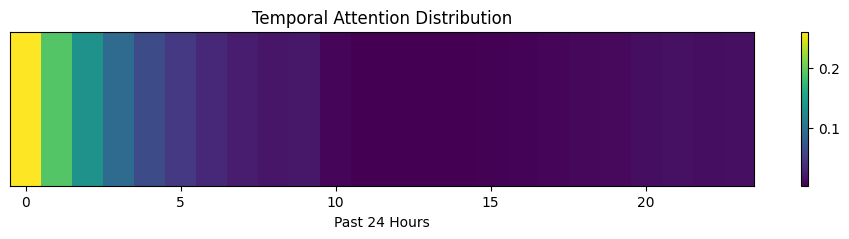

Interpretation: The attention map shows higher weights near recent timesteps,
indicating the model relies more on short-term consumption trends.
Older hours receive lower attention, suggesting diminishing influence.



In [51]:
plt.figure(figsize=(12,2))
plt.imshow(weights[0].T, aspect="auto")
plt.title("Temporal Attention Distribution")
plt.xlabel("Past 24 Hours")
plt.yticks([])
plt.colorbar()
plt.show()

print("""Interpretation: The attention map shows higher weights near recent timesteps,
indicating the model relies more on short-term consumption trends.
Older hours receive lower attention, suggesting diminishing influence.
""")

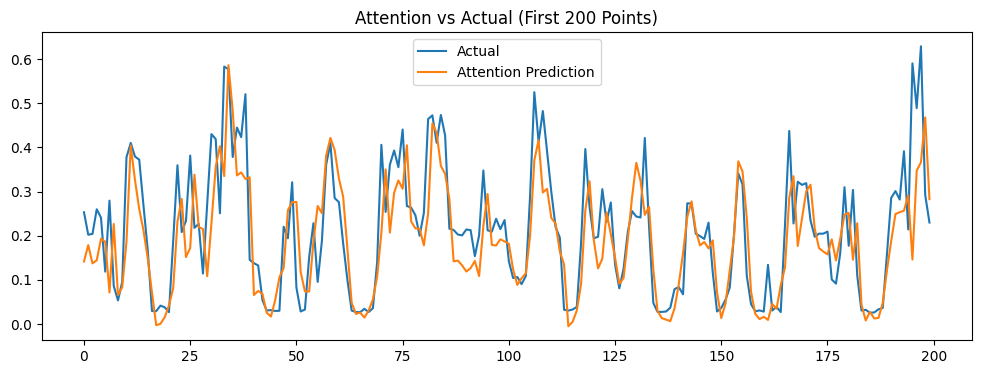

In [52]:
plt.figure(figsize=(12,4))
plt.plot(y_true[:200], label="Actual")
plt.plot(y_pred[:200], label="Attention Prediction")
plt.legend()
plt.title("Attention vs Actual (First 200 Points)")
plt.show()